# Data Generator

In [1]:
IMG_SIZE = 64
BATCH_SIZE = 128
TRAINING_RATIO = 5
GRADIENT_PENALTY_WEIGHT = 10
OUTPUT_SAMPLES = 'imgs'
OUTPUT_DATA = 'data'

In [2]:
import torch, os, random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
%matplotlib inline

PATH = '/home/m20163692/data/lsun'
data = datasets.LSUN(db_path=PATH, classes=['church_outdoor_train'],
    transform=transforms.Compose([
        transforms.Scale(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

minibatches_size = BATCH_SIZE * TRAINING_RATIO
dataloader = torch.utils.data.DataLoader(data, minibatches_size, True, num_workers=8)

def get_batch():
    x = next(iter(dataloader))[0]
    x = x.transpose(1, 3).transpose(1,2).numpy()
    
    return x

# Load Models

In [3]:
import importlib
import models; importlib.reload(models)
from models import make_generator, make_discriminator
import gan_utils; importlib.reload(gan_utils)
from gan_utils import build_gan_arch, generate_images, save_img, save_weights, show

generator = make_generator()
discriminator = make_discriminator()
discriminator_model, generator_model = build_gan_arch(discriminator, generator,
                                                      BATCH_SIZE, GRADIENT_PENALTY_WEIGHT)

# We make three label vectors for training. positive_y is the label vector for real samples, with value 1.
# negative_y is the label vector for generated samples, with value -1. The dummy_y vector is passed to the
# gradient_penalty loss function and is not used.
positive_y = np.ones((BATCH_SIZE, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((BATCH_SIZE, 1), dtype=np.float32)

Using TensorFlow backend.


# Train

In [4]:
# Log files
def write_generator_loss(file, v):
    lines = ''
    if not os.path.exists(file):
        lines += 'generator_loss\n'
    lines += f'{v}\n'
    with open(file, 'a') as f:
        f.writelines(lines)

def write_discriminator_loss(file, v):
    lines = ''
    if not os.path.exists(file):
        lines += 'wgp_loss, disc_real, disc_fake, gp\n'
    lines += ', '.join('%f' % i for i in v)
    lines += '\n'
    with open(file, 'a') as f:
        f.writelines(lines)

discriminator_log_file = os.path.join(OUTPUT_DATA, 'discriminator_log.csv')
generator_log_file = os.path.join(OUTPUT_DATA, 'generator_log.csv')

In [ ]:
epochs = 10000
fixed_noise = np.random.normal(size=(64,128))

# get the highest sampled epoch
last_epoch = [int(f.split('_')[1].split('.')[0]) for f in os.listdir('imgs/') if f[-4:] == '.png']
if len(last_epoch) == 0:
    epochs_range = range(epochs)
else:
    last_epoch = np.max(last_epoch)
    epochs_range = range(last_epoch+1, epochs+last_epoch+1)

print('Number of batches: ', int(data.length // BATCH_SIZE))
for epoch in epochs_range:
    print('Epoch: ', epoch)
    iters = int(data.length // minibatches_size)
    for i in range(iters):
        print(f'{i+1}/{iters}', end='\r')
        discriminator_minibatches = get_batch()
        for j in range(TRAINING_RATIO):
            image_batch = discriminator_minibatches[j * BATCH_SIZE:(j + 1) * BATCH_SIZE]
            noise = np.random.normal(size=(BATCH_SIZE, 128)).astype(np.float32)
            discriminator_loss = discriminator_model.train_on_batch([image_batch, noise],
                                                                    [positive_y, negative_y, dummy_y])
            write_discriminator_loss(discriminator_log_file, discriminator_loss)
            
        noise = np.random.normal(size=(BATCH_SIZE, 128)).astype(np.float32)
        generator_loss = generator_model.train_on_batch(noise, positive_y)
        write_generator_loss(generator_log_file, generator_loss)
    
    save_weights(discriminator, generator)
    generate_images(generator, fixed_noise, OUTPUT_SAMPLES, epoch)

Number of batches:  986
Epoch:  0


In [ ]:
# save_weights(discriminator, generator)

# Results

In [9]:
# load weights
# generator.load_weights('data/lsun_generator.h5')
# discriminator.load_weights('data/lsun_discriminator.h5')

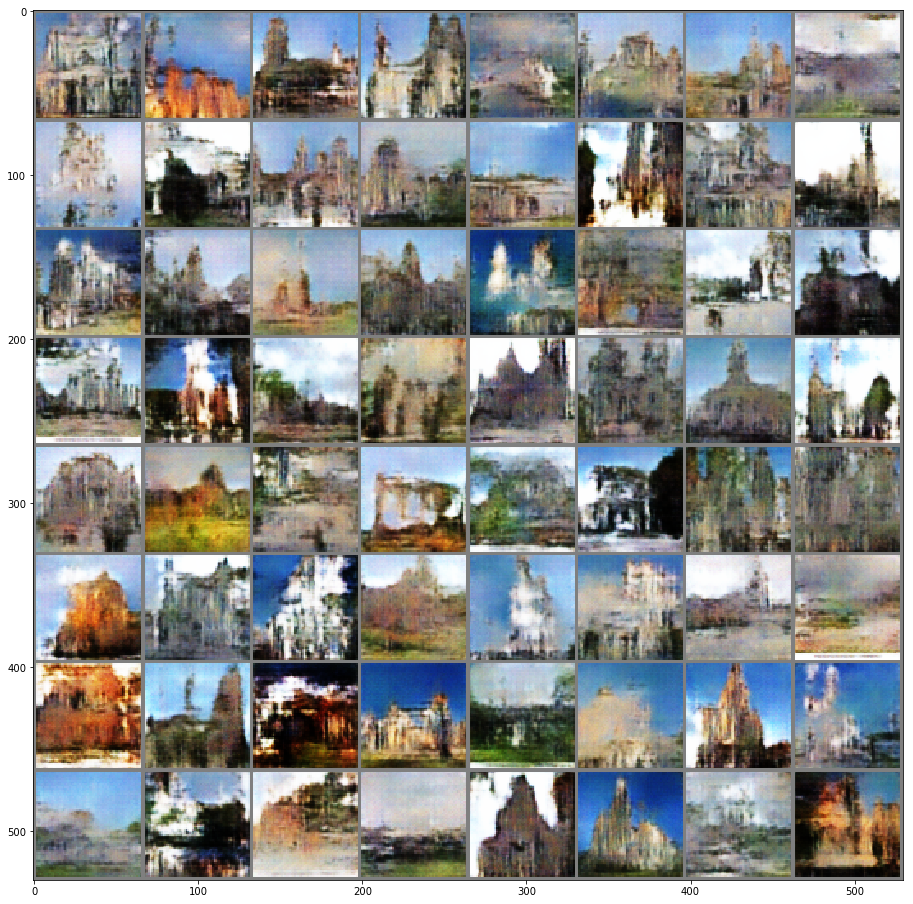

In [74]:
noise = np.random.normal(size=(64, 128)).astype(np.float32)
imgs = generate_images(generator, noise, mode='show')

# Interpolation

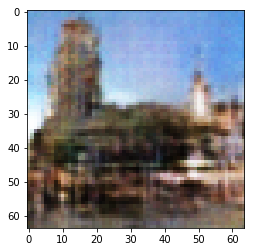

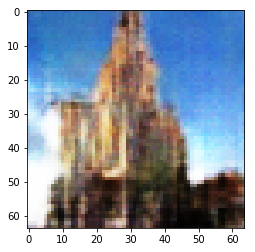

In [136]:
# choose imgs
c1 = 2
c2 = 54

from IPython.display import HTML
from matplotlib import animation, rc

fig, ax = plt.subplots()

def show_img(np_img):
    img = np.clip(np_img/2 + .5, 0, 1)
    plt.imshow(img)
    plt.show()
    
for i in [c1, c2]: show_img(imgs[i])

In [140]:
n_imgs = 100
diff = (noise[c2] - noise[c1]) / n_imgs
noise_interpolation = np.arange(n_imgs+1).reshape((1, n_imgs+1))
noise_interpolation = noise_interpolation.repeat(128, 0).swapaxes(0, 1)
noise_interpolation = noise[c1] + (diff * noise_interpolation)
interpolation = generator.predict(noise_interpolation)
imgs = np.clip(interpolation/2 + .5, 0, 1)

def animate(i):
    ax.imshow(imgs[i], interpolation='nearest')

In [141]:
anim = animation.FuncAnimation(fig, animate, frames=n_imgs+1, interval=100)
HTML(anim.to_html5_video())